# Validation data plots

Plots using data from the MAPPIT and GPCA tests.

In [10]:
from collections import OrderedDict

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.legend_handler import HandlerPatch
from matplotlib_venn import venn2, venn3
import matplotlib as mpl

import ccsblib
from ccsblib import huri
from ccsblib import ccsbplotlib as cplt

from custom_settings import *
from utils import load_space_iii


%matplotlib inline

In [11]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500

In [12]:
val = huri.load_validation_data()
spaceIII = load_space_iii(id_type='orf_id')
val = val.loc[val['orf_id_a'].isin(spaceIII) & val['orf_id_b'].isin(spaceIII), :]
a = val[['orf_id_a', 'orf_id_b']].min(axis=1)
b = val[['orf_id_a', 'orf_id_b']].max(axis=1)
val['orf_id_a'] = a
val['orf_id_b'] = b

In [13]:
qry = """SELECT *
           FROM hi_ref_validation.validation_final_call_all;"""
val_merged = pd.read_sql(qry, ccsblib.paros_connection())
a = val_merged.drop(columns='gpca_score').rename(columns={'mappit_score': 'result'})
a['assay'] = 'MAPPIT'
b = val_merged.drop(columns='mappit_score').rename(columns={'gpca_score': 'result'})
b['assay'] = 'GPCA'
val_m = pd.concat([a, b])
val_m = val_m.rename(columns={'orf_id1': 'orf_id_a', 'orf_id2': 'orf_id_b'})
val_m = val_m.reset_index(drop=True)
val_m = val_m.loc[val_m['orf_id_a'].isin(spaceIII) & val_m['orf_id_b'].isin(spaceIII), :]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [14]:
hi = huri.load_nw_hi_iii(id_type='orf_id')
hi['n_screens_v1'] = hi[['in_screen_1', 'in_screen_2', 'in_screen_3']].sum(axis=1)
hi['n_screens_v2'] = hi[['in_screen_4', 'in_screen_5', 'in_screen_6']].sum(axis=1)
hi['n_screens_v3'] = hi[['in_screen_7', 'in_screen_8', 'in_screen_9']].sum(axis=1)
val = pd.merge(val, hi.loc[:, 
                           ['orf_id_a', 'orf_id_b',
                            'n_screens_v1', 'n_screens_v2', 'n_screens_v3']],
               how='left', on=['orf_id_a', 'orf_id_b'])
val['pair'] = val['orf_id_a'].astype(str) + '_' + val['orf_id_b'].astype(str)

In [15]:
v1_pairs = (val['standard_batch'].isin(['Hvs01', 'Hvs02', 'Hvs03']) &
            val['source'].isin(['Hs01', 'Hs02', 'Hs03']))
v2_pairs = ((val['standard_batch'] == 'Hvs04') &
            val['source'].isin(['Hs04', 'Hs05', 'Hs06']))
v3_pairs = ((val['standard_batch'] == 'Hvs06') &
            val['source'].isin(['Hs07', 'Hs08', 'Hs09']))
for pairs, n_screens_column in [(v1_pairs, 'n_screens_v1'),
                                (v2_pairs, 'n_screens_v2'),
                                (v3_pairs, 'n_screens_v3')]:
    n = (pairs & val[n_screens_column].isnull()).sum()
    if n > 0:
        print('Dropping {} pairs that were tested as screen pairs but are not in HI-III-19'.format(n))       
val = val.drop(val.index[(v1_pairs & val['n_screens_v1'].isnull()) |
                         (v2_pairs & val['n_screens_v2'].isnull()) |
                         (v3_pairs & val['n_screens_v3'].isnull())])

Dropping 16 pairs that were tested as screen pairs but are not in HI-III-19
Dropping 38 pairs that were tested as screen pairs but are not in HI-III-19
Dropping 33 pairs that were tested as screen pairs but are not in HI-III-19


In [31]:
csi = pd.read_csv('../data/processed/Supplementary Table 10.txt', sep='\t')

In [32]:
csi.head()

,orf_id_a,orf_id_b,Y2H_assay_version,category,result,num_screens
0,9,6112,1,HuRI,0.0,1
1,9,6869,1,HuRI,NaN,1
2,9,8359,1,HuRI,0.0,1
3,9,72137,1,HuRI,0.0,1
4,17,5081,1,HuRI,0.0,1


In [33]:
lit = huri.load_nw_lit_17(id_type='orf_id')
csi = pd.merge(csi, lit, 
               how='left',
               left_on=['orf_id_a', 'orf_id_b'], right_on=['orf_id_a', 'orf_id_b'],
               suffixes=('', '_lit'))

In [57]:
gsm_val = pd.read_csv('../data/processed/Supplementary Table 3.txt', sep='\t')

In [58]:
gsm_val.head()

,orf_id_a,orf_id_b,result,experiment,source
0,61,53120,0.0,testing_y2h_v3,Lit_BM_13
1,61,53120,0.0,testing_y2h_v1,Lit_BM_13
2,61,53120,0.0,testing_y2h_v2,Lit_BM_13
3,69,3380,0.0,testing_y2h_v3,Lit_BM_13
4,69,3380,0.0,testing_y2h_v1,Lit_BM_13


In [19]:
val_m.head()

,assay,gpca_id,mappit_id,orf_id_a,orf_id_b,result,source
0,MAPPIT,12394.0,19224.0,34,11996,1.0,lit_bm_2013_rand250
1,MAPPIT,12395.0,19225.0,35,14210,0.0,lit_bm_2013_rand250
2,MAPPIT,942.0,19226.0,48,7587,0.0,lit_bm_2013_rand250
3,MAPPIT,30449.0,19227.0,48,11100,0.0,lit_bm_2013_rand250
4,MAPPIT,5.0,1885.0,65,3769,0.0,Hs01


MAPPIT
HuRI: n=2281	Lit-BM: n=383	RRS: n=475
GPCA
HuRI: n=1639	Lit-BM: n=382	RRS: n=465


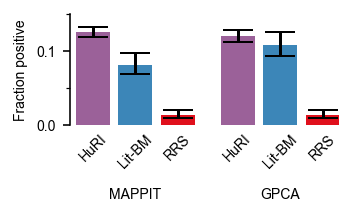

In [20]:
cols = {'HuRI': HURI_COLOR, 'Lit-BM': LIT_COLOR, 'RRS': RRS_COLOR}
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(2.5, 2)
for i, assay in enumerate(['MAPPIT', 'GPCA']):
    rows = OrderedDict([('HuRI', (val_m['assay'] == assay) & 
                                      (val_m['source'].str.startswith('Hs'))),
                        ('Lit-BM', (val_m['assay'] == assay) &
                                   (val_m['source'].isin(['lit_bm_2013_rand250', 'lit_bm_2013_rand400']))),
                        ('RRS', (val_m['assay'] == assay) & 
                                (val_m['source'] == 'RRS'))])
    cplt.validation_plot(data=val_m,
                         selections=list(rows.values()),
                         labels=list(rows.keys()),
                         ax=axes[i],
                         colors=list(cols.values()),
                         draw_numbers=False)
    print(assay)
    print('\t'.join(['{}: n={}'.format(ds, val_m.loc[rs, 'result'].notnull().sum()) for ds, rs in rows.items()]))
    axes[i].set_ylim((0., 0.15))
    axes[i].xaxis.set_tick_params(rotation=45)
    axes[i].xaxis.set_tick_params(length=0.)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].set_facecolor('1.')
axes[1].set_yticks([])
axes[1].set_yticks([], minor=True)
axes[1].set_ylabel('')
axes[1].spines['left'].set_visible(False)
axes[0].text(1, -0.1, 'MAPPIT', ha='center')
axes[1].text(1, -0.1, 'GPCA', ha='center')
plt.tight_layout(w_pad=1)
for fmt in FORMATS:
    plt.savefig('../figures/validation_merged_9screens' + fmt)

In [21]:
# finding the median lit and rrs
for source in ['lit_bm_2013_rand250', 'RRS']:
    for assay in ['MAPPIT', 'GPCA']:
        print(source, assay)
        print(val.loc[(val['source'] == source) & 
                      (val['assay'] == assay) &
                      (val['standard_batch'].isin(['Hvs01', 'Hvs02', 'Hvs03', 'Hvs04', 'Hvs06'])),
                      :]
                 .groupby('standard_batch').apply(lambda x: (x['result'] == 1).sum() / x['result'].notnull().sum())
                 .sort_values())

lit_bm_2013_rand250 MAPPIT
standard_batch
Hvs03    0.069307
Hvs01    0.075472
Hvs02    0.089172
Hvs06    0.093407
Hvs04    0.115702
dtype: float64
lit_bm_2013_rand250 GPCA
standard_batch
Hvs04    0.079137
Hvs02    0.100000
Hvs03    0.112676
Hvs01    0.200000
dtype: float64
RRS MAPPIT
standard_batch
Hvs03    0.008511
Hvs02    0.009772
Hvs04    0.011321
Hvs06    0.012085
Hvs01    0.013158
dtype: float64
RRS GPCA
standard_batch
Hvs01    0.009554
Hvs02    0.012945
Hvs03    0.013245
Hvs04    0.013289
dtype: float64


/Users/lukelambourne/Work/ccsblib/ccsblib/ccsbplotlib/validation.py:146: RuntimeWarning: invalid value encountered in true_divide
  fracs = pos / tested


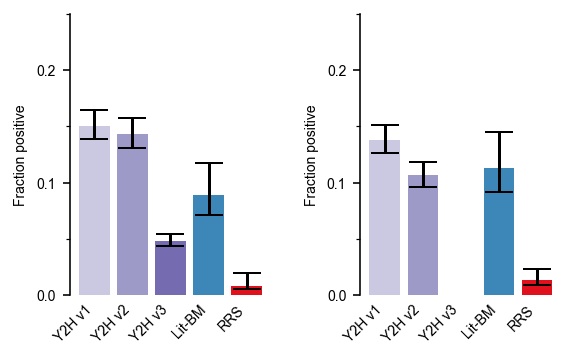

In [22]:
# validation data merged by assay version
colors = {'HI-III-19': HURI_COLOR,
          'Y2H v1': ASSAY_V1_COLOR,
          'Y2H v2': ASSAY_V2_COLOR,
          'Y2H v3': ASSAY_V3_COLOR,
          'Lit-BM': LIT_COLOR,
          'RRS': RRS_COLOR}
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(4., 2.5)
rows = OrderedDict([('Y2H v1', (val['assay'] == 'MAPPIT') & 
                               (val['source'].isin(['Hs01', 'Hs02', 'Hs03']))),
                    ('Y2H v2', (val['assay'] == 'MAPPIT') & 
                               (val['source'].isin(['Hs04', 'Hs05', 'Hs06']))),
                    ('Y2H v3', (val['assay'] == 'MAPPIT') &
                               (val['source'].isin(['Hs07', 'Hs08', 'Hs09']))),
                    ('Lit-BM', (val['assay'] == 'MAPPIT') &
                               (val['source'] == 'lit_bm_2013_rand250') &
                               (val['standard_batch'] == 'Hvs02')),
                    ('RRS', (val['assay'] == 'MAPPIT') & 
                            (val['source'] == 'RRS') &
                            (val['standard_batch'] == 'Hvs03'))])
cplt.validation_plot(data=val,
                     selections=list(rows.values()),
                     labels=list(rows.keys()),
                     ax=axes[0],
                     colors=[colors[k] for k in rows.keys()],
                     draw_numbers=False)
rows = OrderedDict([('Y2H v1', (val['assay'] == 'GPCA') & 
                               (val['source'].isin(['Hs01', 'Hs02', 'Hs03']))),
                    ('Y2H v2', (val['assay'] == 'GPCA') & 
                               (val['source'].isin(['Hs04', 'Hs05', 'Hs06']))),
                    ('Y2H v3', (val['assay'] == 'GPCA') &
                               (val['source'] == 'experiment_not_done')),
                    ('Lit-BM', (val['assay'] == 'GPCA') &
                               (val['source'] == 'lit_bm_2013_rand250') &
                               (val['standard_batch'] == 'Hvs03')),
                    ('RRS', (val['assay'] == 'GPCA') & 
                            (val['source'] == 'RRS') &
                            (val['standard_batch'] == 'Hvs03'))])
cplt.validation_plot(data=val,
                     selections=list(rows.values()),
                     labels=list(rows.keys()),
                     ax=axes[1],
                     colors=[colors[k] for k in rows.keys()],
                     draw_numbers=False)
for ax in axes:
    ax.set_ylim((0., 0.25))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.xaxis.set_tick_params(length=0.)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor('1.')
plt.tight_layout(w_pad=2.5)
for fmt in FORMATS:
    plt.savefig('../figures/validation_merged_assay_versions' + fmt)

For the screen pairs they were done in 5 experiments, 3 (Hvs01/2/3) for the first screen, and 1 each for screens 4-6 and 7-9 (Hvs04 / Hvs06).

Screen 1: n=280	Lit-BM: n=159	RRS: n=304
Screen 2: n=271	Lit-BM: n=157	RRS: n=307
Screen 3: n=206	Lit-BM: n=101	RRS: n=235
Screen 4: n=246	Screen 5: n=244	Screen 6: n=229	Lit-BM: n=274	RRS: n=265
Screen 7: n=236	Screen 8: n=233	Screen 9: n=239	Lit-BM: n=182	RRS: n=331


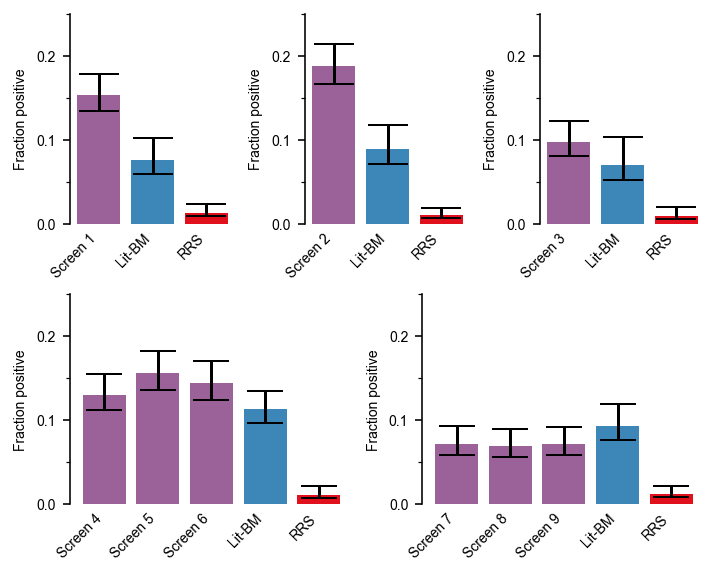

In [24]:
def validation_by_screen_by_experiment(assay):
    colors = {'Screen {}'.format(i): HURI_COLOR for i in range(1, 10)}
    colors['Lit-BM'] = LIT_COLOR
    colors['RRS'] = RRS_COLOR
    fig, _axes = plt.subplots(3, 3)
    axes = [plt.subplot2grid((2, 6), (0, 0), colspan=2),
            plt.subplot2grid((2, 6), (0, 2), colspan=2),
            plt.subplot2grid((2, 6), (0, 4), colspan=2),
            plt.subplot2grid((2, 6), (1, 0), colspan=3),
            plt.subplot2grid((2, 6), (1, 3), colspan=3)]
    fig.set_size_inches(5, 4)
    for i in range(1, 4):
        sb = 'Hvs0' + str(i)
        rows = OrderedDict([('Screen ' + str(i), (val['assay'] == assay) &
                                                         (val['standard_batch'] == sb) &
                                                         (val['source'] == 'Hs0' + str(i))),
                            ('Lit-BM', (val['assay'] == assay) &
                                       (val['standard_batch'] == sb) &
                                       (val['source'] == 'lit_bm_2013_rand250')),
                            ('RRS', (val['assay'] == assay) &
                                    (val['standard_batch'] == sb) &
                                    (val['source'] == 'RRS'))])
        cplt.validation_plot(data=val, 
                             selections=list(rows.values()),
                             labels=list(rows.keys()),
                             ax=axes[i - 1],
                             colors=[colors[k] for k in rows.keys()], 
                             draw_numbers=False)
        print('\t'.join(['{}: n={}'.format(ds, val.loc[rs, 'result'].notnull().sum()) for ds, rs in rows.items()]))
    sb = 'Hvs04'
    rows = OrderedDict([('Screen ' + str(i), (val['assay'] == assay) &
                                                     (val['standard_batch'] == sb) &
                                                     (val['source'] == 'Hs0' + str(i)))
                       for i in range(4, 7)] +
                       [
                        ('Lit-BM', (val['assay'] == assay) &
                                   (val['standard_batch'] == sb) &
                                   (val['source'].isin(['lit_bm_2013_rand250', 'lit_bm_2013_rand400']))),
                        ('RRS', (val['assay'] == assay) &
                                (val['standard_batch'] == sb) &
                                (val['source'] == 'RRS'))])
    cplt.validation_plot(data=val,
                         selections=list(rows.values()),
                         labels=list(rows.keys()),
                         ax=axes[3],
                         colors=[colors[k] for k in rows.keys()],
                         draw_numbers=False)
    print('\t'.join(['{}: n={}'.format(ds, val.loc[rs, 'result'].notnull().sum()) for ds, rs in rows.items()]))
    sb = 'Hvs06'
    rows = OrderedDict([('Screen ' + str(i), (val['assay'] == assay) &
                                                     (val['standard_batch'] == sb) &
                                                     (val['source'] == 'Hs0' + str(i)))
                       for i in range(7, 10)] +
                       [
                        ('Lit-BM', (val['assay'] == assay) &
                                   (val['standard_batch'] == sb) &
                                   (val['source'] == 'lit_bm_2013_rand250')),
                        ('RRS', (val['assay'] == assay) &
                                (val['standard_batch'] == sb) &
                                (val['source'] == 'RRS'))])
    if any([r.sum() > 0 for r in rows.values()]):
        cplt.validation_plot(data=val,
                             selections=list(rows.values()),
                             labels=list(rows.keys()),
                             ax=axes[4],
                             colors=[colors[k] for k in rows.keys()],
                             draw_numbers=False)
        print('\t'.join(['{}: n={}'.format(ds, val.loc[rs, 'result'].notnull().sum()) for ds, rs in rows.items()]))
    else:
        axes[4].axis('off')

    for ax in axes:
        ax.set_ylim((0., 0.25))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.xaxis.set_tick_params(length=0.)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_facecolor('1.')
        ax.set_title('')
    
    
validation_by_screen_by_experiment('MAPPIT')
plt.tight_layout()
for fmt in FORMATS:
    plt.savefig('../figures/validation_mappit_by_screen_by_experiment' + fmt)

Screen 1: n=252	Lit-BM: n=155	RRS: n=314
Screen 2: n=255	Lit-BM: n=150	RRS: n=309
Screen 3: n=255	Lit-BM: n=142	RRS: n=302
Screen 4: n=278	Screen 5: n=257	Screen 6: n=263	Lit-BM: n=303	RRS: n=301


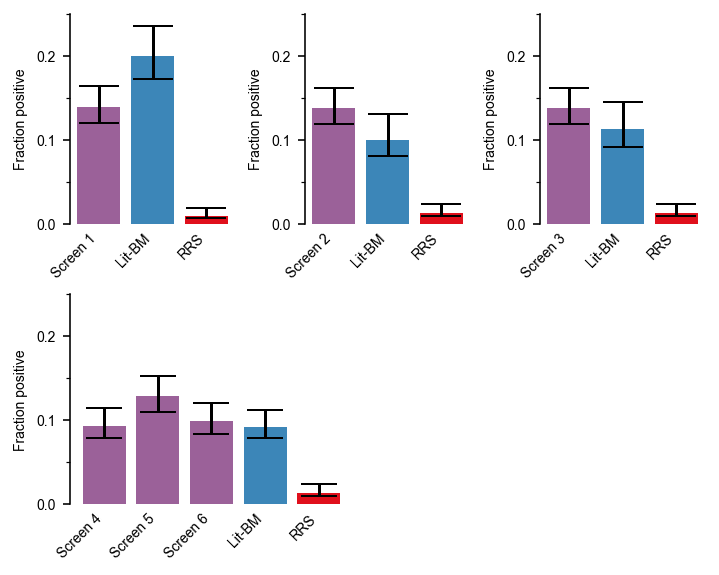

In [25]:
validation_by_screen_by_experiment('GPCA')
plt.tight_layout()
for fmt in FORMATS:
    plt.savefig('../figures/validation_gpca_by_screen_by_experiment' + fmt)

In [37]:
csi.category.unique()

array(['HuRI', 'Lit_and_HuRI'], dtype=object)

HuRI
1 screens: n=759	2 screens: n=407	3 screens: n=298
1 screens: n=793	2 screens: n=328	3 screens: n=197
1 screens: n=497	2 screens: n=259	3 screens: n=135
Lit_and_HuRI
1 screens: n=325	2 screens: n=334	3 screens: n=440
1 screens: n=310	2 screens: n=138	3 screens: n=43
1 screens: n=141	2 screens: n=56	3 screens: n=22


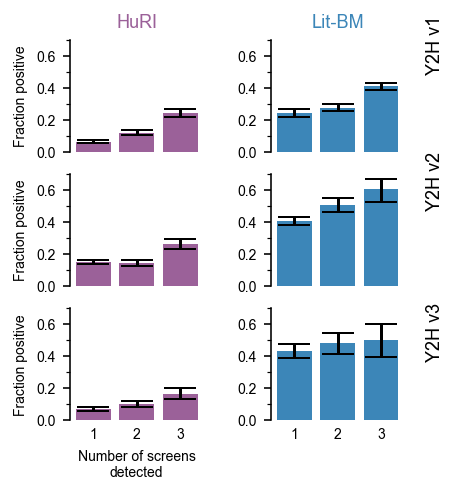

In [41]:
# assay versions
# axis labels
ymax = 0.7
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(3, 3.5)
plt.subplots_adjust(wspace=0.5)
for i, cat in enumerate(['HuRI', 'Lit_and_HuRI']):
    print(cat)
    for j, assay_id in enumerate([1, 2, 3]):
        rows = {str(i) + ' screens': (csi['Y2H_assay_version'] == assay_id) &
                                     (csi['category'] == cat) &
                                     (csi['num_screens'] == i)
                for i in range(1, 4)}
        colors = {str(i) + ' screens': {'HuRI': HURI_COLOR, 'Lit_and_HuRI': LIT_COLOR}[cat] for i in range(1, 4)}
        cplt.validation_plot(data=csi, 
                             selections=list(rows.values()),
                             labels=list(rows.keys()),
                             result_column='result',
                             ax=axes[j, i],
                             y_max=ymax,
                             colors=list(colors.values()),
                             draw_numbers=False)
        print('\t'.join(['{}: n={}'.format(ds, csi.loc[rs, 'result'].notnull().sum()) for ds, rs in rows.items()]))
        ax = axes[j, i]
        ax.xaxis.set_tick_params(length=0.)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_facecolor('1.')
        ax.set_xticklabels([])
        ax.set_yticks(np.arange(0., 0.71, 0.2))
        ax.set_yticks(np.arange(0., 0.71, 0.1), minor=True)
        
axes[2, 1].set_xticklabels([1, 2, 3], rotation=0)
axes[2, 0].set_xticklabels([1, 2, 3], rotation=0)
axes[2, 0].set_xlabel('Number of screens\ndetected')
axes[0, 1].set_ylabel('')
axes[1, 1].set_ylabel('')
axes[2, 1].set_ylabel('')


fig.text(0.95, 0.82, 'Y2H v1', fontsize=9, rotation=90)
fig.text(0.95, 0.55, 'Y2H v2', fontsize=9, rotation=90)
fig.text(0.95, 0.25, 'Y2H v3', fontsize=9, rotation=90)

axes[0, 0].set_title('HuRI', color=HURI_COLOR, fontsize=9)
axes[0, 1].set_title('Lit-BM', color=LIT_COLOR, fontsize=9)


for fmt in FORMATS:
    plt.savefig('../figures/validation_mappit_by_num_screens' + fmt,
                bbox_inches='tight')

In [27]:
csi.head()

,orf_id_a,orf_id_b,Y2H_assay_version,category,result,num_screens,binary_low_throughput,binary_not_y2h,binary,n_publications,n_methods,n_evidences,category_lit
0,9,6112,1,HuRI,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,6869,1,HuRI,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,8359,1,HuRI,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,72137,1,HuRI,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17,5081,1,HuRI,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Evidence count ≥ 3
1 screens: n=61	2 screens: n=56	3 screens: n=105
Evidence count ≥ 4
1 screens: n=48	2 screens: n=44	3 screens: n=74
Evidence count ≥ 5
1 screens: n=40	2 screens: n=34	3 screens: n=59
Evidence count ≥ 6
1 screens: n=31	2 screens: n=28	3 screens: n=45
Evidence count ≥ 7
1 screens: n=25	2 screens: n=24	3 screens: n=34


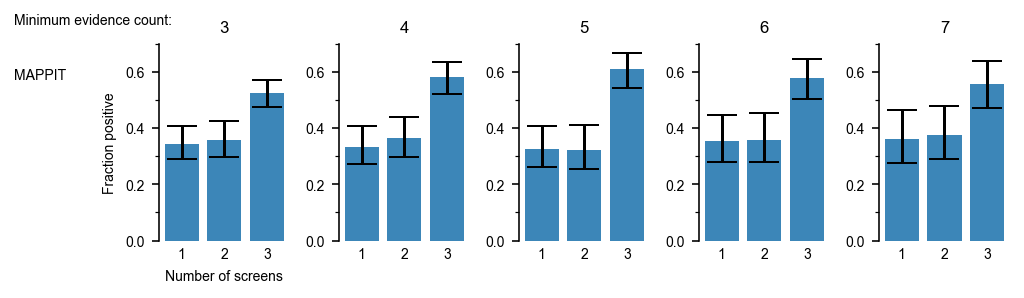

In [53]:
def val_by_n_screens_restrict_lit_evid(n_evid, val_assay='mappit', ymax=0.7, ax=None):
    cat = 'Lit_and_HuRI'
    assay_id = 1
    rows = {str(i) + ' screens': (csi['Y2H_assay_version'] == assay_id) &
                                 (csi['category'] == cat) &
                                 ((csi['category'] == 'HuRI') | 
                                  (csi['category_lit'].isin(['Lit-BM', 'Lit-BM-HT']) & (csi['n_evidences'] > n_evid)))  &
                                 (csi['num_screens'] == i)
            for i in range(1, 4)}
    colors = {str(i) + ' screens': {'HuRI': HURI_COLOR, 'Lit_and_HuRI': LIT_COLOR}[cat] for i in range(1, 4)}
    cplt.validation_plot(data=csi,
                         selections=list(rows.values()),
                         result_column='result',
                         ax=ax,
                         y_max=ymax,
                         colors=list(colors.values()),
                         draw_numbers=False)
    print('Evidence count ≥', n_evid)
    print('\t'.join(['{}: n={}'.format(ds, csi.loc[rs, 'result'].notnull().sum()) for ds, rs in rows.items()]))
    ax.xaxis.set_tick_params(length=0.)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor('1.')


n_evidences = list(range(3, 8))
fig, axes = plt.subplots(1, len(n_evidences))
# figure size
fig.set_size_inches(6.5, 2)
for n in n_evidences:
    val_by_n_screens_restrict_lit_evid(n, 'mappit', 0.7, axes[n - 3])
for ax in axes.flatten():
    ax.set_yticks([0.1, 0.3, 0.5, 0.7], minor=True)
    ax.set_yticks([0., 0.2, 0.4, 0.6])
for ax in axes[1:].flatten():
    ax.set_ylabel('')
for ax in axes:
    ax.set_xticklabels(['1', '2', '3'], rotation=0)
for ax, n in zip(axes, n_evidences):
    ax.set_title(str(n))
axes[0].set_xlabel('Number of screens')
fig.text(-0.08, 0.75, 'MAPPIT')
fig.text(-0.08, 0.938, 'Minimum evidence count:')
plt.tight_layout()
for fmt in FORMATS:
    plt.savefig('../figures/validation_num_screens_lit_bm' + fmt,
                bbox_inches='tight')

In [60]:
gsm_val.head()

,orf_id_a,orf_id_b,result,experiment,source
0,61,53120,0.0,testing_y2h_v3,Lit_BM_13
1,61,53120,0.0,testing_y2h_v1,Lit_BM_13
2,61,53120,0.0,testing_y2h_v2,Lit_BM_13
3,69,3380,0.0,testing_y2h_v3,Lit_BM_13
4,69,3380,0.0,testing_y2h_v1,Lit_BM_13


In [61]:
gsm_val.source.unique()

array(['Lit_BM_13', 'RRS', 'test_space_y2h_v3', 'test_space_y2h_v1',
       'test_space_y2h_v2'], dtype=object)

In [62]:
gsm_val.experiment.unique()

array(['testing_y2h_v3', 'testing_y2h_v1', 'testing_y2h_v2'], dtype=object)

Y2H v1
Y2H: n=395	Lit-BM: n=216	RRS: n=349
Y2H v2
Y2H: n=161	Lit-BM: n=214	RRS: n=175
Y2H v3
Y2H: n=310	Lit-BM: n=211	RRS: n=315


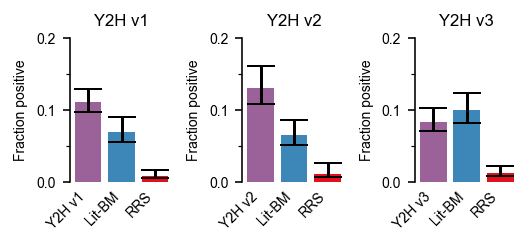

In [65]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(3.7, 1.7)
ymax = 0.2
assay = 'MAPPIT'
gsm_v1_exp = [(gsm_val['experiment'] == 'testing_y2h_v1') &
              (gsm_val['source'] == s) for s in ['test_space_y2h_v1',
                                             'Lit_BM_13',
                                             'RRS']]
gsm_v2_exp = [(gsm_val['experiment'] == 'testing_y2h_v2') &
              (gsm_val['source'] == s) for s in ['test_space_y2h_v2',
                                             'Lit_BM_13',
                                             'RRS']]
gsm_v3_exp = [(gsm_val['experiment'] == 'testing_y2h_v3') &
              (gsm_val['source'] == s) for s in ['test_space_y2h_v3',
                                             'Lit_BM_13',
                                             'RRS']]
cplt.validation_plot(data=gsm_val,
                     selections=gsm_v1_exp,
                     ax=axes[0],
                     y_max=ymax,
                     labels=['Y2H v1', 'Lit-BM', 'RRS'],
                     colors=[HURI_COLOR, LIT_COLOR, RRS_COLOR],
                     draw_numbers=False)
cplt.validation_plot(data=gsm_val,
                     selections=gsm_v2_exp,
                     ax=axes[1],
                     y_max=ymax,
                     labels=['Y2H v2', 'Lit-BM', 'RRS'],
                     colors=[HURI_COLOR, LIT_COLOR, RRS_COLOR],
                     draw_numbers=False)
cplt.validation_plot(data=gsm_val,
                     selections=gsm_v3_exp,
                     ax=axes[2],
                     y_max=ymax,
                     labels=['Y2H v3', 'Lit-BM', 'RRS'],
                     colors=[HURI_COLOR, LIT_COLOR, RRS_COLOR],
                     draw_numbers=False)
dataset_names = ['Y2H', 'Lit-BM', 'RRS']
print('Y2H v1')
print('\t'.join(['{}: n={}'.format(ds, gsm_val.loc[rs, 'result'].notnull().sum()) for ds, rs in zip(dataset_names, gsm_v1_exp)]))
print('Y2H v2')
print('\t'.join(['{}: n={}'.format(ds, gsm_val.loc[rs, 'result'].notnull().sum()) for ds, rs in zip(dataset_names, gsm_v2_exp)]))
print('Y2H v3')
print('\t'.join(['{}: n={}'.format(ds, gsm_val.loc[rs, 'result'].notnull().sum()) for ds, rs in zip(dataset_names, gsm_v3_exp)]))
for ax in axes.flatten():
    ax.xaxis.set_tick_params(length=0.)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_facecolor('1.')
axes[0].set_title('Y2H v1')
axes[1].set_title('Y2H v2')
axes[2].set_title('Y2H v3')
plt.tight_layout()
for fmt in FORMATS:
    plt.savefig('../figures/gsm_gsm_validation_mappit' + fmt,
                bbox_inches='tight')